In [1]:
from pickle import loads

import matplotlib.pyplot as plt
from pandas import DataFrame
from numpy import linspace, pi, abs, sin, cos, sign, diag, log
from numpy.polynomial.legendre import Legendre
from cytoolz import pipe, partial
from pymongo import MongoClient
from lmfit.models import ExpressionModel, ConstantModel 
from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import curve_fit

from vmitools import Hist2d, convert_df_xy2rth, finite_legendre_transform_in_theta

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Modules 'dbpy', 'stpy' are not imported!


In [2]:
db = MongoClient('frege.duia.pro')['FERMI_20144077']

bad_runs = (
    178,  # good1
    464, 468,  # good2
    186, 196, *range(198, 204),  # alt1
    *range(266, 272), *range(292, 315),  # alt2
    359,  # alt3
    453, 454)  # alt4
ignore_bad_runs = partial(filter, lambda n: n not in bad_runs)
runs = pipe(
    range(461, 463),  # wonly3
    ignore_bad_runs, sorted, tuple)
imgs = pipe(db['reconstructed'].find({'run': {'$in': runs}}), list, DataFrame)
loaded = DataFrame({'run': imgs['run'],
                    'n': imgs['n'],
                    'edges': imgs['edges'].map(loads),
                    'hist': imgs['hist'].map(loads)})
del imgs

/app/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


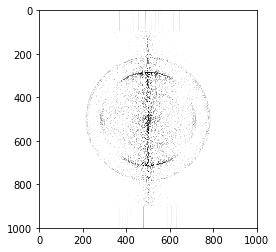

In [3]:
weighted = DataFrame({
    'summed': loaded['hist'] * loaded['n'],
    'n': loaded['n'],
})
total_summed = weighted[['n', 'summed']].apply(sum)
total_img = total_summed['summed'] / total_summed['n']
del weighted, total_summed

plt.imshow(log(total_img.T), cmap='Greys')
plt.clim(-6, -3)

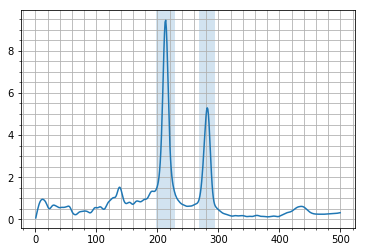

In [4]:
def centers(arr):
    return (arr[1:]+arr[:-1])/2


z_edges = loaded['edges'].iloc[0]
r_edges = linspace(0, 500, 501)
th_edges = linspace(-pi, pi, 361)
nlim = 8
r = centers(r_edges)
th = centers(th_edges)

reconstructed = Hist2d(gaussian_filter(total_img, 3), z_edges, z_edges)
# reconstructed = Hist2d(reconstructed_img, z_edges, z_edges)
polarized = Hist2d(None, r_edges, th_edges)  # shape=(r,th)
polarized.intensity = convert_df_xy2rth(lambda z, r: reconstructed.intensity(r, z))
weighted = polarized.copy
weighted.intensity = lambda r, th: polarized.intensity(r, th)*abs(r*sin(th))*pi

plt.plot(r, polarized.hist.sum(1))
plt.axvspan(213-15.99*1, 213+15.99*1, alpha=0.2)
plt.axvspan(281.5-12.69*1, 281.5+12.69*1, alpha=0.2)
plt.minorticks_on()
plt.grid(True, which='both')

In [5]:
def legendre_curve(th, *coeff):
    return Legendre(coeff)(cos(th))


def betas(z_edges, reconstructed_img, fr=float('-inf'), to=float('inf')) -> dict:
    reconstructed = Hist2d(gaussian_filter(reconstructed_img, 3), z_edges, z_edges)
#     reconstructed = Hist2d(reconstructed_img, z_edges, z_edges)
    polarized = Hist2d(None, r_edges, th_edges)  # shape=(r,th)
    polarized.intensity = convert_df_xy2rth(lambda z, r: reconstructed.intensity(r, z))

    where = (fr < r) & (r < to)
    weighted = polarized.copy
    weighted.intensity = lambda r, th: polarized.intensity(r, th)*abs(r*sin(th))*pi
    top = weighted.hist[where, :][:, (0 < th) & (th < pi/2)].sum()
    btm = weighted.hist[where, :][:, (pi/2 < th) & (th < pi)].sum()
    pad = polarized.hist[where, :].sum(0)
    _, coeff, _ = finite_legendre_transform_in_theta(  # shapes=(n,r)(n,th)
        pad,
        polarized.y_edges,
        nlim+1,
    )
    opt, cov = curve_fit(legendre_curve, th, pad, p0=5*[1])
    var = diag(cov)
    err = abs(opt/opt[0]) * (var/opt**2 + var[0]/opt[0]**2) ** 0.5
    return {
        'asym': (top-btm)/(top+btm),
        **{'beta{:1d}'.format(i): coeff[i]/coeff[0] for i in range(1, nlim+1)},
        **{'beta{:1d}_opt'.format(i): opt[i]/opt[0] for i in range(1, 5)},
        **{'beta{:1d}_err'.format(i): err[i] for i in range(1, 5)},
    }


df_he = pipe([total_img],
             partial(map, partial(betas, z_edges, fr=213-15.99*1, to=213+15.99*1)), list, DataFrame)
df_ne = pipe([total_img],
             partial(map, partial(betas, z_edges, fr=281.5-12.69*1, to=281.5+12.69*1)), list, DataFrame)
df = df_he.add_prefix("he_").join(df_ne.add_prefix("ne_"))

# Beta Spectra of Data Set *wonly3*
## *Helium* Photoelectron

In [6]:
df[[k for k in sorted(df) if 'he_' in k]]

,he_asym,he_beta1,he_beta1_err,he_beta1_opt,he_beta2,he_beta2_err,he_beta2_opt,he_beta3,he_beta3_err,he_beta3_opt,he_beta4,he_beta4_err,he_beta4_opt,he_beta5,he_beta6,he_beta7,he_beta8
0,-0.028134,-0.08547,0.025002,-0.073952,0.550625,0.034043,0.524631,-0.089317,0.03426,-0.001807,1.738705,0.049565,1.809047,-0.027242,0.07462,-0.049239,-0.055543


## *Neon* Photoelectron

In [7]:
df[[k for k in sorted(df) if 'ne_' in k]]

,ne_asym,ne_beta1,ne_beta1_err,ne_beta1_opt,ne_beta2,ne_beta2_err,ne_beta2_opt,ne_beta3,ne_beta3_err,ne_beta3_opt,ne_beta4,ne_beta4_err,ne_beta4_opt,ne_beta5,ne_beta6,ne_beta7,ne_beta8
0,-0.015987,-0.053509,0.010815,-0.075027,-0.46938,0.014665,-0.491166,-0.00837,0.014832,0.083487,0.052199,0.016972,0.150859,0.048607,0.130437,-0.088121,-0.07373
